# Importing Data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from tqdm import tqdm
tqdm.pandas()

In [2]:
data = pd.read_csv("../input/machine-hack-fake-news-content-detection/Train.csv")

**Variable Description:**

Text - Raw content from social media/ new platforms

Text_Tag - Different types of content tags

Labels - Represents various classes of Labels
* Half-True - 2
* False - 1
* Mostly-True - 3
* True - 5
* Barely-True - 0
* Not-Known - 4

In [3]:
print(data.shape)
data.head()

(10240, 3)


,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


# Distribution of Target Variable

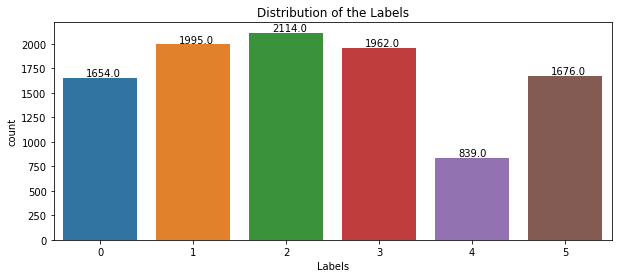

In [4]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x="Labels", data=data)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels")
plt.show()

# Cleaning Text

In [5]:
data['Original Text'] = data['Text']

In [6]:
print("Original text: ")

print(data['Text'][0])

Original text: 
Says the Annies List political group supports third-trimester abortions on demand.


In [7]:
data["Text"] = data["Text"].str.lower()

In [8]:
stopwords_ = set(stopwords.words('english'))

def stopwords_removal(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_])

tqdm.pandas()
data['Text'] = data['Text'].progress_apply(lambda text: stopwords_removal(text))

100%|██████████| 10240/10240 [00:00<00:00, 196070.67it/s]


In [9]:
print("After removing stopwords: ")

print(data['Text'][0])

After removing stopwords: 
says annies list political group supports third-trimester abortions demand.


In [10]:
punctuations= list(string.punctuation)

def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['Text'] = data['Text'].progress_apply(lambda text: cleaning_punctuations(text))

100%|██████████| 10240/10240 [00:00<00:00, 185858.52it/s]


In [11]:
print("After removing punctuations: ")

print(data['Text'][0])

After removing punctuations: 
says annies list political group supports thirdtrimester abortions demand


# Word Cloud for Fake News

In [12]:
from wordcloud import WordCloud 

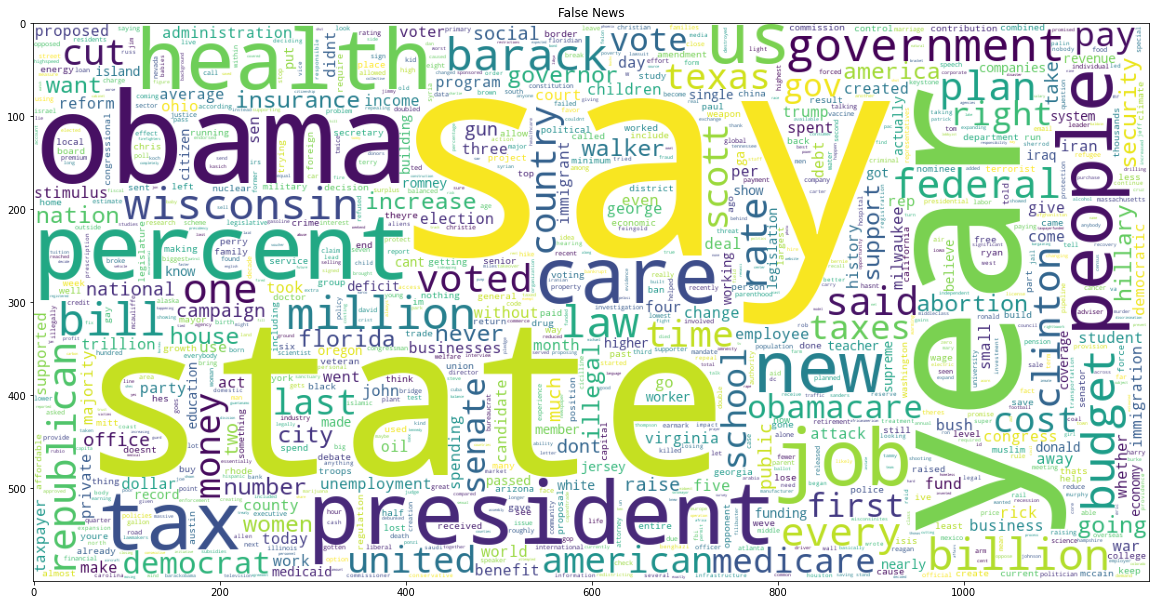

In [13]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(data[data['Labels']==1]['Text']))
plt.figure(figsize = (20,20))
plt.title("False News")
plt.imshow(wc)

# Data Preparation 

In [14]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa

In [15]:
num_classes = (data['Labels'].nunique())

In [16]:
X = data['Text']
y = tf.keras.utils.to_categorical(data['Labels'], num_classes)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
#print(train_word_index)

In [19]:
train_tokenizer

In [20]:
vocab_length = len(train_word_index) + 1
vocab_length

12028

In [21]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [22]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [23]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

# RNN Model

In [24]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

2022-09-11 12:12:40.007980: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 6)             72168     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20, 64)            4544      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 32)            3104      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [25]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))

Epoch 1/20


2022-09-11 12:12:40.373022: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


256/256 [==============================] - 10s 29ms/step - loss: 1.7751 - f1_score: 0.1506 - val_loss: 1.7709 - val_f1_score: 0.1259
Epoch 2/20
256/256 [==============================] - 6s 25ms/step - loss: 1.7358 - f1_score: 0.1832 - val_loss: 1.7866 - val_f1_score: 0.1403
Epoch 3/20
256/256 [==============================] - 6s 25ms/step - loss: 1.6139 - f1_score: 0.2820 - val_loss: 1.8449 - val_f1_score: 0.1574
Epoch 4/20
256/256 [==============================] - 6s 24ms/step - loss: 1.3760 - f1_score: 0.4246 - val_loss: 2.0690 - val_f1_score: 0.1813
Epoch 5/20
256/256 [==============================] - 6s 25ms/step - loss: 1.1057 - f1_score: 0.5774 - val_loss: 2.3310 - val_f1_score: 0.1994
Epoch 6/20
256/256 [==============================] - 7s 27ms/step - loss: 0.8563 - f1_score: 0.6934 - val_loss: 2.6044 - val_f1_score: 0.1821
Epoch 7/20
256/256 [==============================] - 6s 25ms/step - loss: 0.6585 - f1_score: 0.7740 - val_loss: 3.0031 - val_f1_score: 0.1776
Epoch 8/2

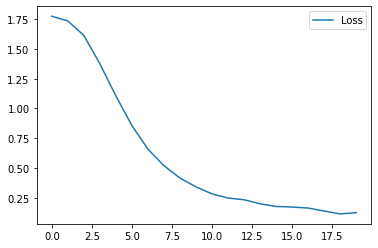

In [26]:
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.show()

In [27]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 1s 11ms/step - loss: 5.4507 - f1_score: 0.1713


[5.4506659507751465,
 array([0.18079096, 0.21208385, 0.20279722, 0.21479714, 0.08609272,
        0.1312608 ], dtype=float32)]

In [28]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

# Model Performance

In [29]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix

In [30]:
print("Log-Loss =", log_loss(y_test, test_prob))

Log-Loss = 5.450666600821664


In [31]:
print("F1-Score =", f1_score(y_test, test_pred, average = 'weighted'))

F1-Score = 0.17418201084244736


In [32]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
cm = multilabel_confusion_matrix(y_test, test_pred)

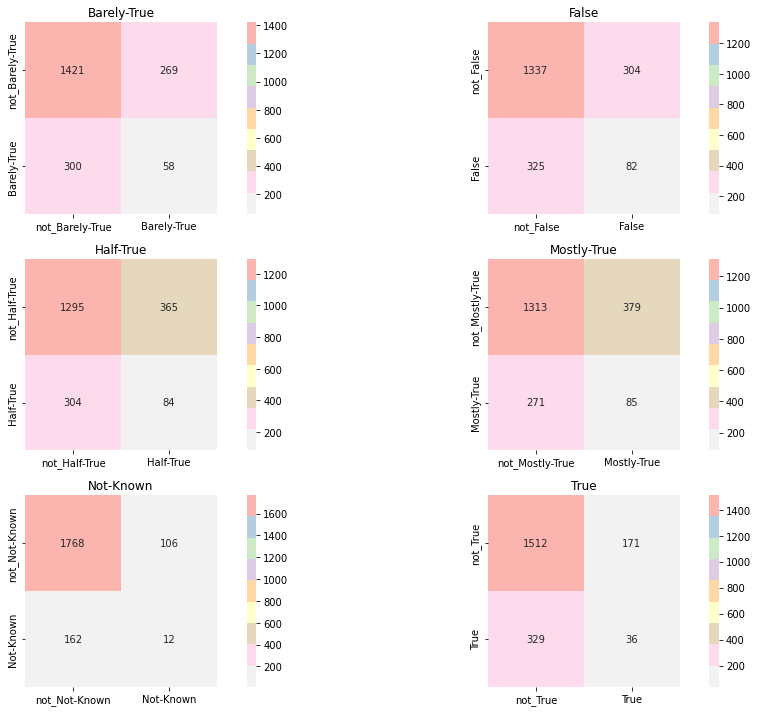

In [33]:
fig = plt.figure(figsize = (15, 10))
for i, (label, matrix) in enumerate(zip(labels, cm)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, cmap='Pastel1_r', fmt='d')
    plt.title(label)
    
plt.tight_layout()
plt.show()